# MPI-GE vs. Emulator Sensitivity Histograms

## Import Modules

In [ ]:
# General imports
import numpy as np
from tqdm import tqdm
import string
import re

# Data handling imports
import xarray as xr

# Plotting imports
import matplotlib.pyplot as plt

# Statistics imports
from scipy import stats 
from scipy.stats import norm
from statsmodels.regression.linear_model import yule_walker
import statsmodels.api as sm

# Custom imports
import functions.helper as hlp
import functions.siametadata as meta
import functions.memberhandling as mbhl
import functions.emulator_func as em

## Load Data

In [3]:
basepath = "/Users/quraus001/Documents/Uni/SIA-Sensitivity-Uncertainty/"

datapath = basepath + "data/"
plotpath = basepath + "plots/MPI-GE/"

save_plots = False

In [5]:
# Model data
DF = {}
for scenario in ["ssp245", "ssp370", "ssp585"]:
    DF[scenario] = mbhl.load_model_data(inpath=datapath + "MPI-ESM2-1-LR/sia_nh/", scenario=scenario)
members = list(DF[scenario].columns)[:-3]
members = sorted(members, key=lambda x: int(re.search(r'r(\d+)i', x).group(1)))

# CO2 Data
cmip6_ds = xr.open_dataset(datapath +"co2/CMIP6_co2_emissions_ssp.nc")
df_co2 = cmip6_ds.to_dataframe().cumsum(axis=0)
df_co2.index = df_co2.index.astype(int)

## Collect Mean Meta Data

In [8]:
start, stop = 1979, 2024

Obs_sens_MPI    = {"ssp245":[],"ssp370":[],"ssp585":[]} # sensitivity of "observation" period
AR1_coeff_MPI   = {"ssp245":[],"ssp370":[],"ssp585":[]} # autocorrelation coeffiecient #not spline corrected

Intercept_MPI   = {"ssp245":[],"ssp370":[],"ssp585":[]} # intercept form the regression
MEANS = {"ssp245":[],"ssp370":[],"ssp585":[]} # Dict for saving all the means

for scenario in ["ssp245", "ssp370", "ssp585"]:
    for mb in members:
        sens, y_pred, lin_timing, intercept = meta.get_meta_data(DF[scenario].loc[start:stop][mb].values, df_co2.loc[start:stop][scenario].values)
  
        Intercept_MPI[scenario].append(intercept)
        Obs_sens_MPI[scenario].append(sens)

        residuals = DF[scenario][mb].loc[start:stop] - y_pred
        rho, sigma = yule_walker(residuals, order=1)
        ar1_corrcoef = rho[0] + ((1+4*rho)/len(residuals))
        AR1_coeff_MPI[scenario].append(ar1_corrcoef.item())

    mean_ensemble_spread = np.mean(DF[scenario].loc[1979:2024].iloc[:,:-3].std(axis=1))

    # Save mean quantaties
    MEANS[scenario] = {"sens":np.mean(Obs_sens_MPI[scenario]), 
                       "ar1_coef": np.mean(AR1_coeff_MPI[scenario]),
                       "ensemble_spread" : mean_ensemble_spread}

## Plotting

ssp245
       Mean, std, IQR, Skewness, Kurtosis
data1: -1.381, 0.262, 0.409, 0.297, -0.431
data2: -1.381, 0.145, 0.196, -0.010, -0.011
       Mean, std, IQR, Skewness, Kurtosis
data1: -1.381, 0.262, 0.409, 0.297, -0.431
data2: -1.381, 0.240, 0.325, -0.010, -0.005


/Users/quraus001/miniforge3/envs/emulator/lib/python3.10/site-packages/matplotlib/axes/_axes.py:7096: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/Users/quraus001/miniforge3/envs/emulator/lib/python3.10/site-packages/matplotlib/axes/_axes.py:7097: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


plot was saved as: /Users/quraus001/Documents/Uni/Thesis/Paper/Rebuild-MPI-ESM-sens-hists.png
plot was saved as: /Users/quraus001/Documents/Uni/Thesis/Paper/Rebuild-MPI-ESM-sens-hists.pdf


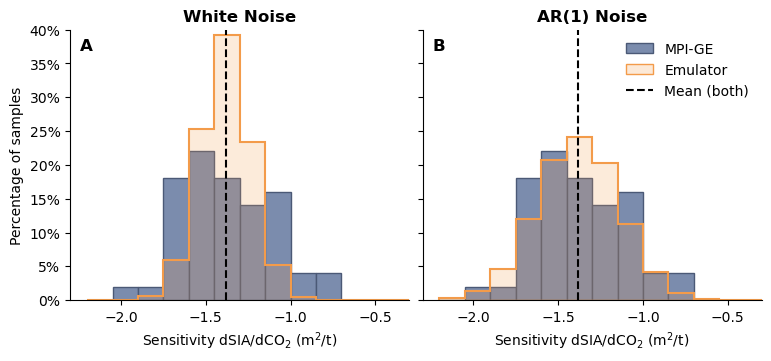

In [ ]:
member=members[0]
seed = 10
runs = 100000
scenario="ssp245"
print(scenario)
from matplotlib.ticker import PercentFormatter
np.random.seed(seed)

params = {"df_forcing": df_co2,
          "df_sia"    : DF[scenario],
          "runs"      : runs,
          "observation_start": 1979,
          "observation_end"  : 2024,
          "true_slope": MEANS[scenario]["sens"],
          "intercept" : 6, # technically could be any number
          "amplitude" : MEANS[scenario]["ensemble_spread"],
          "ar1_corrcoef": MEANS[scenario]["ar1_coef"],
          "co2_name"  : scenario,
          "sigma_correction" : True,
          "noise_type" : "white",
          "phi_correction":True}

# Create Emulator members and Calculate sensitivity
np.random.seed(seed)
Sensitivities_white = em.experiment(**params)[0]
params["noise_type"] = "ar1"
np.random.seed(seed)
Sensitivities_ar1 = em.experiment(**params)[0]


fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(3.8*2,3.5*1), sharey=True, constrained_layout=True)#5,4#

# Set histogram bins
binwidth = 0.15
bins = np.arange(-2.2, 0.4 + binwidth, binwidth)

data1 = Obs_sens_MPI[scenario]

for ax, data2 in zip([ax1, ax2], [Sensitivities_white, Sensitivities_ar1]):
    ax.hist(data1, bins, weights=np.ones(len(data1)) / len(data1), color="#7B8CAD", edgecolor="#4B5976", label="MPI-GE")
    ax.hist(data2, alpha=1, bins=bins, histtype="step", color="#F39B4A", linewidth=1.5, weights=np.ones(len(data2)) / len(data2))
    ax.hist(data2, alpha=0.2, bins=bins, color="#F39B4A", weights=np.ones(len(data2)) / len(data2))

    print("       Mean, std, IQR, Skewness, Kurtosis")
    print(f"data1: {np.mean(data1):1.3f}, {np.std(data1):1.3f}, {stats.iqr(data1):1.3f}, {stats.skew(data1):1.3f}, {stats.kurtosis(data1):1.3f}")
    print(f"data2: {np.mean(data2):1.3f}, {np.std(data2):1.3f}, {stats.iqr(data2):1.3f}, {stats.skew(data2):1.3f}, {stats.kurtosis(data2):1.3f}")

    # Format axes
    ax.set_xlim(-2.3,-0.3)
    ax.set_ylim(0, 0.4)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
    ax.set_xlabel("Sensitivity dSIA/dCO$_2$ (m$^2$/t)")
    ax.set_xticks(np.arange(-2,0,0.5))

# Format axes
for ax, letter in zip([ax1,ax2],["A","B"]):
    ax.text(.03, .922, letter, fontweight="bold", transform=ax.transAxes, fontsize=12, zorder=10)

ax2.hist([np.nan], bins, color="#F39C4A37", edgecolor="#F39B4A", label="Emulator")

ax1.axvline(x=np.mean(Obs_sens_MPI[scenario]), linestyle="--", color="black", label="Mean (both)")
ax2.axvline(x=np.mean(Obs_sens_MPI[scenario]), linestyle="--", color="black", label="Mean (both)")

ax1.set_ylabel("Percentage of samples")
ax1.set_title("White Noise", fontweight="bold")
ax2.set_title("AR(1) Noise", fontweight="bold")
ax2.legend(frameon=False)

hlp.save_plot(plotpath + "Rebuild-MPI-ESM-sens-hists", save_plots=save_plots, file_types=["png","pdf"], dpi=300)
plt.show()